# Outliers detection
## Application à la détection de non-qualités dans du code source

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

pylab.rcParams['figure.figsize'] = (10.0, 8.0)
pylab.rcParams['figure.dpi'] = 100

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## Chargement de la donnée

KC2 Software defect prediction
One of the NASA Metrics Data Program defect data sets. Data from software for science data processing. Data comes from McCabe and Halstead features extractors of source code. These features were defined in the 70s in an attempt to objectively characterize code features that are associated with software quality.

Sayyad Shirabad, J. and Menzies, T.J. (2005) The PROMISE Repository of Software Engineering Databases. School of Information Technology and Engineering, University of Ottawa, Canada

[https://www.openml.org/d/1063](https://www.openml.org/d/1063)

Le dataset n'est pas hyper représentatif de la problématique (et pas forcément déséquilibré), mais l'idée est de vérifier si une approche entièrement non-supervisée peut s'approcher d'une approche supervisée

In [5]:
raw_data = pd.read_csv('../data/kc2.csv', header=0)

In [6]:
raw_data.head(5)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,lOCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,problems
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,1.30,1.30,2,2,2,2,1.2,1.2,1.2,1.2,1.4,no
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1,1,1,1,1.0,1.0,1.0,1.0,1.0,yes
2,415.0,59.0,50.0,51.0,1159.0,8411.31,0.01,103.53,81.24,870848.58,2.80,48380.48,359,35,9,10,47.0,106.0,692.0,467.0,106.0,yes
3,230.0,33.0,10.0,16.0,575.0,3732.82,0.03,39.82,93.74,148644.06,1.24,8258.00,174,15,34,5,23.0,67.0,343.0,232.0,65.0,yes
4,175.0,26.0,12.0,13.0,500.0,3123.96,0.03,29.48,105.96,92103.07,1.04,5116.84,142,7,19,4,18.0,58.0,310.0,190.0,51.0,yes


In [7]:
raw_data.shape

(522, 22)

In [8]:
target_id = 'problems'
target_value = 'yes'

In [9]:
raw_data[target_id].value_counts()

no     415
yes    107
Name: problems, dtype: int64

### Création du dataset

In [10]:
X = raw_data.sample(len(raw_data))
X = X.reset_index(drop=True)
X[target_id] = X[target_id].map(lambda x: 1 if x == target_value else 0)
y = X[target_id]
del X[target_id]
y_true = y

In [11]:
X.head(5)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,lOCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,194.0,23.0,1.0,11.0,504.0,3204.21,0.02,43.41,73.81,139096.88,1.07,7727.60,137,23,29,1,26.0,56.0,317.0,187.0,45.0
1,64.0,6.0,1.0,6.0,185.0,977.80,0.05,19.32,50.61,18891.08,0.33,1049.50,49,7,5,0,14.0,25.0,116.0,69.0,11.0
2,4.0,2.0,1.0,1.0,11.0,36.54,0.40,2.50,14.62,91.35,0.01,5.08,2,0,0,0,5.0,5.0,6.0,5.0,3.0
3,4.0,1.0,1.0,1.0,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,1.0,0.0,1.0,0.0,1.0
4,4.0,1.0,1.0,1.0,4.0,8.00,0.67,1.50,5.33,12.00,0.00,0.67,2,0,0,0,3.0,1.0,3.0,1.0,1.0


On normalise les valeurs (préférable pour les métriques de clustering).

In [12]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X = pd.DataFrame(mms.fit_transform(X),columns=X.columns)

In [1]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import MinCovDet
from sklearn.cluster import DBSCAN, AgglomerativeClustering, MiniBatchKMeans
from sklearn.ensemble import VotingClassifier

from bdacore.outliers import CovarianceOutliers
from bdacore.outliers import GMMOutliers
from bdacore.outliers import ClusteringOutliers
from bdacore.outliers import KMeansOneClusterOutliers

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

### Calcul d'un premier score avec approche supervisée

On prend comme baseline le résultat brute (sans optim) d'une RF

In [15]:
clf_rf = RandomForestClassifier(n_estimators=40, n_jobs=-1, random_state=42)
y_pred = cross_val_predict(clf_rf,X,y,method='predict_proba', cv=5)

In [16]:
y_test = y_pred[:,1]

In [17]:
fpr, tpr, _ = roc_curve(y_true, y_test)

In [18]:
auc(fpr, tpr)

0.81763314942011034

**Baseline auc: 0.818**<br/>
Donc une approche supervisée fait le job basiquement.

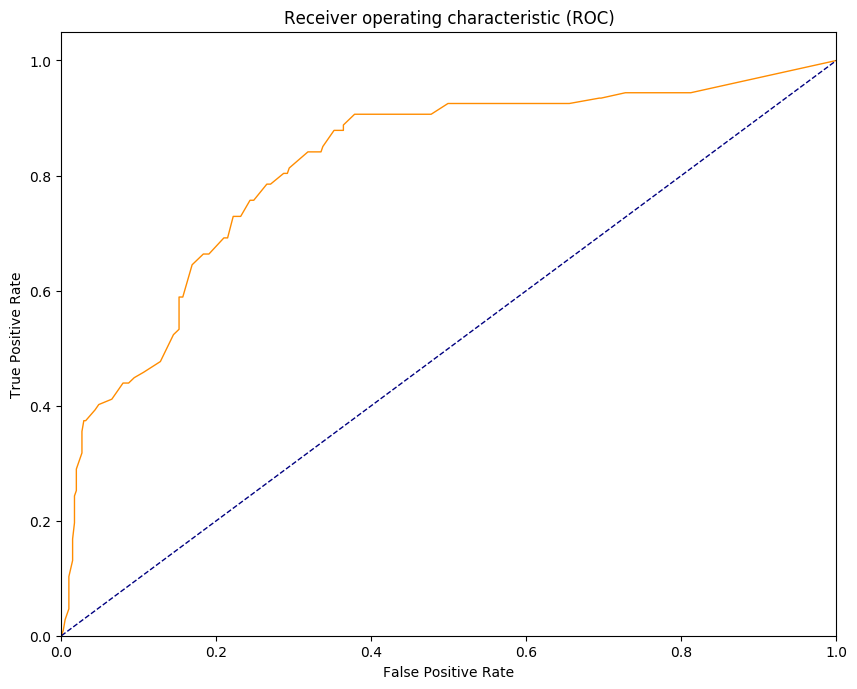

In [19]:
plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.show()

On garde de côté le tpr (True Positive Rate) et le fpr (False Positive Rate) de la RF pour comparer avec les approches non-supervisées.

In [20]:
tpr_rf = tpr
fpr_rf = fpr

## Approches non-supervisées

### Exemple de classe sklearn: Isolation Forest

Test avec une classe déjà existante de sklearn:

In [21]:
clf_isoforest = IsolationForest(n_jobs=-1, n_estimators=40, random_state=42)

In [22]:
clf_isoforest.fit(X)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=40, n_jobs=-1, random_state=42,
        verbose=0)

In [23]:
y_test = 1 - clf_isoforest.decision_function(X)
fpr, tpr, _ = roc_curve(y_true, y_test)

In [24]:
auc(fpr, tpr)

0.8314604211237473

L'approche IsolationForest amène les mêmes résultats qu'avec une RF, ce qui est plutôt pas mal.

### Classes BDAcore: CovarianceOutliers, GMMOutliers, ClusteringOutliers
#### Calcul du score pour chaque modèle

In [25]:
# petit fonction utilitaire pour mesurer les performances
def auc_outliers_estimator(X, y_true, estimator):
    estimator.fit(X)
    y_test = estimator.predict_proba(X)
    fpr, tpr, _ = roc_curve(y_true, y_test)
    return auc(fpr, tpr)

In [26]:
# voir la doc pour chaque estimateur
score_per_estimator = {}

In [31]:
score = auc_outliers_estimator(X,y_true,CovarianceOutliers())
score_per_estimator['CovarianceOutlier'] = score
print(score)

0.8193334084


In [32]:
score = auc_outliers_estimator(X,y_true,GMMOutliers())
score_per_estimator['GMMOutlier'] = score
print(score)

0.780193671884


In [40]:
# peut être compliqué à paramétrer pour faire apparaître des éléments n'appartement à aucun clustering
score = auc_outliers_estimator(X,y_true,
                       ClusteringOutliers(cluster_estimator=DBSCAN(min_samples=2,eps=0.01), strategy='unclustered'))
score_per_estimator['ClusteringOutlier_unclustered'] = score
print(score)

0.71471681117


In [44]:
# assez instable en fonction du random_state
score = auc_outliers_estimator(X,y_true,
ClusteringOutliers(cluster_estimator=MiniBatchKMeans(n_clusters=10), 
                                         strategy='size'))
score_per_estimator['ClusteringOutlier_size'] = score
print(score)

0.824051345569


In [50]:
score = auc_outliers_estimator(X,y_true,
ClusteringOutliers(cluster_estimator=MiniBatchKMeans(n_clusters=10), 
                                         strategy='frontier'))
score_per_estimator['ClusteringOutlier_frontier'] = score
print(score)

0.722519986488


In [56]:
score = auc_outliers_estimator(X,y_true,
                       ClusteringOutliers(cluster_estimator=AgglomerativeClustering(n_clusters=20), 
                                         strategy='density'))
score_per_estimator['ClusteringOutlier_density'] = score
print(score)

0.735378898773


In [57]:
pd.DataFrame({'auc' : score_per_estimator})

,auc
ClusteringOutlier_density,0.735379
ClusteringOutlier_frontier,0.722520
ClusteringOutlier_size,0.824051
ClusteringOutlier_unclustered,0.714717
CovarianceOutlier,0.819333
GMMOutlier,0.780194


#### Blending des modèles

In [58]:
rstate = 42

In [59]:
# packaging de l'IsolationForest pour obtenir un vrai predict_proba
class MetaIsoForest(IsolationForest):
    def __init__(self, **kwargs):
        super(MetaIsoForest, self).__init__(**kwargs)
    
    def predict_proba(self, X):
        return 1 - self.decision_function(X)

Après moultes tests, je n'en garde que quelques-uns:

In [80]:
clf_list = [('Cov',CovarianceOutliers(MinCovDet(random_state=rstate))),
            #('GMM',GMMOutliers(gmm_estimator=BayesianGaussianMixture(n_components=1))),
            ('Clust_unclust',ClusteringOutliers(cluster_estimator=DBSCAN(min_samples=2), strategy='unclustered')),
            ('Kmoc', KMeansOneClusterOutliers(kmeans_estimator=MiniBatchKMeans(n_clusters=1,random_state=rstate))),
            #('Clust_size',ClusteringOutliers(cluster_estimator=MiniBatchKMeans(n_clusters=10,random_state=rstate), strategy='size')),
            #('Clust_density',ClusteringOutliers(cluster_estimator=AgglomerativeClustering(n_clusters=20), strategy='density')),
            ('Clust_frontier',ClusteringOutliers(cluster_estimator=MiniBatchKMeans(n_clusters=5, random_state=rstate), strategy='frontier')),
            ('IsoForest', MetaIsoForest(n_jobs=-1, random_state=rstate))
]

Blending par un Voting Classifier:

In [81]:
clf_vote = VotingClassifier(estimators=clf_list,voting='soft')

Pour le fit, le y ne sert à rien (non-supervisé), c'est juste que le contrat du VotingClassifier est fait comme ça.

In [82]:
clf_vote.fit(X,y)

VotingClassifier(estimators=[('Cov', CovarianceOutliers(cov_estimator=MinCovDet(assume_centered=False, random_state=42, store_precision=True,
     support_fraction=None),
          threshold=None)), ('Clust_unclust', ClusteringOutliers(cluster_estimator=DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclide...rams=None, rtol=0),
          strategy='frontier', threshold=None)), ('IsoForest', MetaIsoForest())],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [83]:
y_test = clf_vote.predict_proba(X)

In [84]:
fpr, tpr, _ = roc_curve(y_true, y_test)

In [85]:
auc(fpr, tpr)

0.83048080171151895

On pourrait dire que le blending n'augmente pas les perfs (certains modèles seuls font mieux), mais en le relançant plusieurs fois, il stabilise les prédictions.

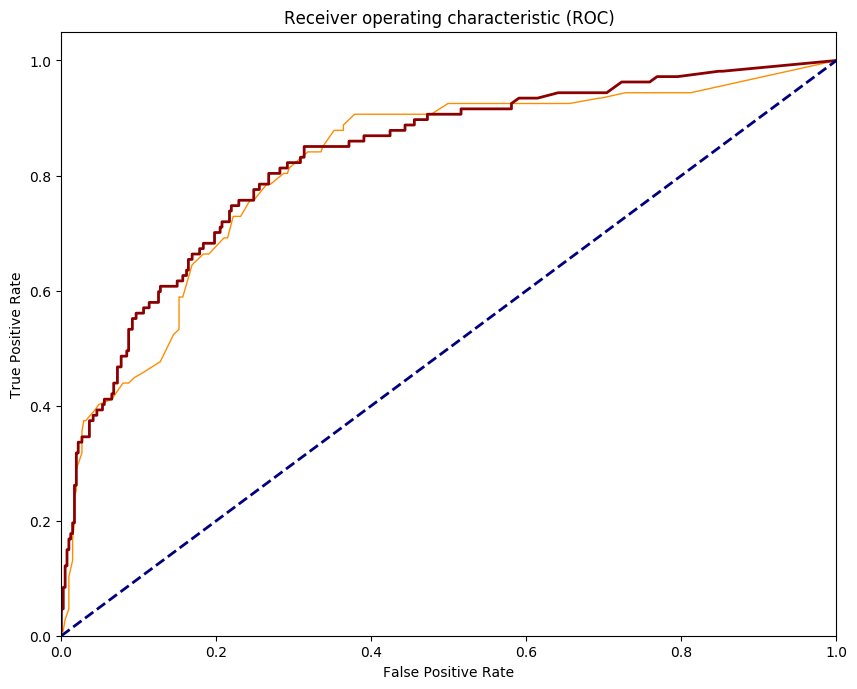

In [86]:
plt.figure()
lw = 1
plt.plot(fpr_rf, tpr_rf, color='darkorange',lw=lw)
lw = 2
plt.plot(fpr, tpr, color='darkred',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.show()

#### Debrief:
L'idée de comparer sur un jeu de données "facile" une approche supervisée et non-supervisée, permet de vérifier que l'approche non-supervisée peut obtenir au moins le même score que l'approche supervisée. 
Il y a bien sûr un certain nombre de biais dans ce notebook comme le dataset lui-même, le non-tuning des modèles, etc. et les "modèles" non-supervisés de bdacore peuvent certainement être améliorés, mais leur utilisation sur un dataset sans labels pour la recherche d'outliers peut être envisagée.